In [ ]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_MultiShapeCirclesTranslation as model

torch.set_default_tensor_type(torch.DoubleTensor)

In [33]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,0.])
o2 = torch.tensor([10.,0.])
origin = [o1,o2]
r1 = 1.
r2 = 2.
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0,5], [10,-5]]
target = mm.multipleCircles(origin, [2., 1.], nb_pts)

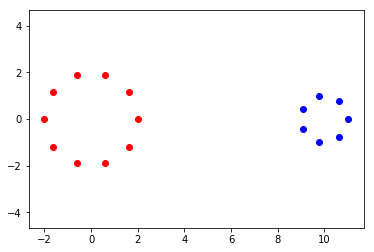

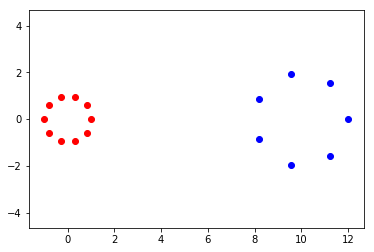

In [34]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [35]:
# Defining the deformation modules
sigma1 = 3
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
#man_local1 = dm.manifold.Landmarks(2,1)
#scal1 = dm.deformationmodules.LocalScaling(man_local1, sigma1)

sigma2 = 3
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
#trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
#man_local2 = dm.manifold.Landmarks(2,1)
#scal2 = dm.deformationmodules.LocalScaling(man_local2, sigma2)

#module_list = [scal1, scal2]
#sigma_bg = 0.1
#modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [36]:
scal1 = dm.deformationmodules.GlobalScaling(manifold1, sigma1)
scal2 = dm.deformationmodules.GlobalScaling(manifold2, sigma2)
module_list = [scal1, scal2]
sigma_bg = 0.1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [37]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [38]:
#gd0_list = [mm.computeCenter(source[0]), mm.computeCenter(source[1]), [mm.computeCenter(source[0]), mm.computeCenter(source[1])]]
#mom0_list = [torch.zeros(dim), torch.zeros(dim), [torch.zeros(dim), torch.zeros(dim)]]

In [39]:
gd0_list = [*source, source]
mom0_list = [*[torch.zeros(gd.shape) for gd in modules.manifold.gd[:-1]], [torch.zeros(gd.shape) for gd in modules.manifold.gd[-1]]]

In [40]:
H.module.manifold.fill_gd([gd0_list[0].view(-1), gd0_list[1].view(-1), [gd0_list[2][0].view(-1), gd0_list[2][1].view(-1)]])
H.module.manifold.fill_cotan([mom0_list[0].view(-1), mom0_list[1].view(-1), [mom0_list[2][0].view(-1), mom0_list[2][1].view(-1)]])
H.geodesic_controls()

In [41]:
H.geodesic_controls()
H.module.controls
modules.module_list[0].manifold.gd

tensor([ 2.0000e+00,  0.0000e+00,  1.6180e+00,  1.1756e+00,  6.1803e-01,
         1.9021e+00, -6.1803e-01,  1.9021e+00, -1.6180e+00,  1.1756e+00,
        -2.0000e+00,  2.4493e-16, -1.6180e+00, -1.1756e+00, -6.1803e-01,
        -1.9021e+00,  6.1803e-01, -1.9021e+00,  1.6180e+00, -1.1756e+00],
       grad_fn=<ViewBackward>)

In [42]:
# set parameters
reg_param = 10**-2 # regularisation parameter

gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2][0], gd0_list[2][1]],0).requires_grad_().view(-1)
mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2][0], mom0_list[2][1]],0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

cost: 0.0219073174146 attach: 12.305825199870924
 iter : 0  ,total energy: 12.327732517285506
cost: 0.0219073174146 attach: 12.305825199870924
cost: 0.0218739389926 attach: 12.302985042515495
cost: 0.0218574383487 attach: 12.301564965751652
cost: 0.0218329230914 attach: 12.29943485300212
cost: 0.0217966805502 attach: 12.296239689278664
cost: 0.0217435100138 attach: 12.291446955876818
cost: 0.0216664390791 attach: 12.28425788329324
cost: 0.0215568736341 attach: 12.273474336698458
cost: 0.0214061176199 attach: 12.257299158173
cost: 0.0212105659438 attach: 12.233036712692655
cost: 0.020986048706 attach: 12.19664378427842
cost: 0.0208040959715 attach: 12.142056107266255
cost: 0.0208795188943 attach: 12.060178633379714
cost: 0.021776445334 attach: 11.937372179771536
cost: 0.0248853671184 attach: 11.753186987219914
cost: 0.0335166970759 attach: 11.476974686859322
cost: 0.0553915733939 attach: 11.062851702908612
cost: 0.10829162098 attach: 10.442387298538824
cost: 0.232839091855 attach: 9.516

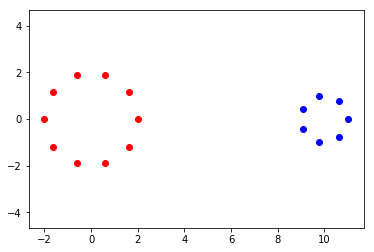

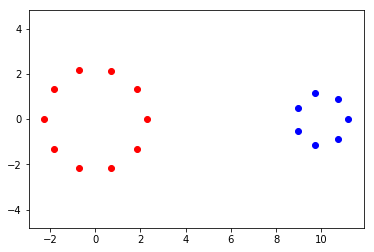

In [45]:
plt.figure()
plt.scatter(gd0_list[0].view(-1,2)[:, 0].detach().numpy(), gd0_list[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd0_list[1].view(-1,2)[:, 0].detach().numpy(), gd0_list[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')

gd_moved = EnergyFunctional.h.module.manifold.gd

plt.figure()
plt.scatter(gd_moved[0].view(-1,2)[:, 0].detach().numpy(), gd_moved[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_moved[1].view(-1,2)[:, 0].detach().numpy(), gd_moved[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.show()

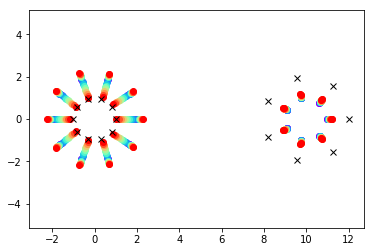

In [46]:
H.module.manifold.fill_gd(EnergyFunctional.tensor2list(X[0]))
H.module.manifold.fill_cotan(EnergyFunctional.tensor2list(X[1]))

states, controls = dm.shooting.shoot_euler(H, it=10)


import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s.gd[0].view(-1,2)[:, 0].detach().numpy(), s.gd[0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[1].view(-1,2)[:, 0].detach().numpy(), s.gd[1].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][1].view(-1,2)[:, 0].detach().numpy(), s.gd[2][1].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    
plt.axis('equal')
plt.show()

In [47]:
# 2 Modules
def controlslist2tensor(controls_list):
    return torch.cat([controls_list[0].view(-1),controls_list[1].view(-1), controls_list[-1][0].view(-1),controls_list[-1][1].view(-1)])

def controlstensor2list(controls, nb_pts, dim):
    n = sum(nb_pts)
    return [controls[:dim*nb_pts[0]], controls[dim*nb_pts[0]:dim*(nb_pts[0]+nb_pts[1])], [controls[dim*n:dim*(n+nb_pts[0])], controls[dim*(n+nb_pts[0]):]]]

def gdtensor2list(gdtensor, nb_pts, dim):
    gdlist = []
    gdlist_bg = []
    j = 0
    n = sum(nb_pts)
    for i in range(len(nb_pts)):
        gdlist.append(gdtensor[dim*j:dim*(j+nb_pts[i])])
        gdlist_bg.append(gdtensor[dim*(n+j):dim*(n+j+nb_pts[i])])
        j = j + nb_pts[i]
    return [*gdlist, gdlist_bg]

def gdlist2tensor(gdlist):
    return torch.cat([*gdlist[:-1],*gdlist[-1]],0)

nb_pts = [nb_pts1, nb_pts2]

In [48]:
def test_gradcheck_Hamiltonian_2modules():
    def hamiltonian(gd, mom, controls, l):
        
        H.module.fill_l(l)
        H.module.manifold.fill_gd(gdtensor2list(gd, [nb_pts1, nb_pts2], dim))
        H.module.manifold.fill_cotan(controlstensor2list(mom, [nb_pts1, nb_pts2], dim))
        H.module.fill_controls(controlstensor2list(controls, [nb_pts1, nb_pts2], dim))
        H.geodesic_controls()
        
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom, controls, modules.l), raise_exception=True)

modules.compute_geodesic_variables(constr_Id)

gd = gdlist2tensor(modules.manifold.gd)
mom = controlslist2tensor(modules.manifold.cotan)
controls = controlslist2tensor(modules.controls)
l = modules.l

test_gradcheck_Hamiltonian_2modules()

True